In [230]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV , ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import calendar
from pandas.api.types import CategoricalDtype
from plotnine import *
#import ggplot
from plotnine.data import mpg
import import_ipynb
import nbimporter
import fn as fn
%matplotlib inline

In [231]:
#Read 6 csv files (3 for Seattle, 3 for Boston) into different dataframes

sea_listings=pd.read_csv("sea_listings.csv")
sea_calendar=pd.read_csv("sea_calendar.csv")
sea_reviews=pd.read_csv("sea_reviews.csv")
bos_listings=pd.read_csv("bos_listings.csv")
bos_calendar=pd.read_csv("bos_calendar.csv")
bos_reviews=pd.read_csv("bos_reviews.csv")

In [232]:
def to_date_time(col):
    '''
    INPUT
    col - column to be converted as datatime

    OUTPUT
    pd.to_datetime(col) - column, which is converted as datetime.
    '''
    return pd.to_datetime(col)

In [233]:
def plot_y(df, x_col, y_col1, y_col2, x_label, y_label, title, kind):
    '''
    INPUT
    df - pandas dataframe
    x_col - x-axis column, dataframe column
    y_col1 - y-axis first column, dataframe column
    y_col2 - y-axis second column, dataframe column
    x_label - label for x-axis
    y_label - label for y-axis
    title - title of the plot
    kind - kind decides what type of plot it is such as bar, line, etc

    OUTPUT
    plot show - A plot using all input values
    '''
    
    df.plot(x=x_col, y=[y_col1, y_col2], figsize=(10,4), kind=kind)
    plt.title(title,fontsize=16)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    plt.show()

In [234]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [235]:
# Remove "$", "%", "," and then convert the column values to float

sea_listings["price"]=sea_listings.price.str.replace('$','').str.replace(',','').astype(float)
sea_listings["weekly_price"]=sea_listings.weekly_price.str.replace('$','').str.replace(',','').astype(float)
sea_listings["monthly_price"]=sea_listings.monthly_price.str.replace('$','').str.replace(',','').astype(float)
sea_listings["security_deposit"]=sea_listings.security_deposit.str.replace('$','').str.replace(',','').astype(float)
sea_listings["cleaning_fee"]=sea_listings.cleaning_fee.str.replace('$','').str.replace(',','').astype(float)
sea_listings["host_response_rate"]=sea_listings.host_response_rate.str.replace('%','').str.replace(',','').astype(float)
sea_listings["host_acceptance_rate"]=sea_listings.host_acceptance_rate.str.replace('%','').str.replace(',','').astype(float)
sea_listings["extra_people"]=sea_listings.extra_people.str.replace('$','').str.replace(',','').astype(float)

bos_listings["price"]=bos_listings.price.str.replace('$','').str.replace(',','').astype(float)
bos_listings["weekly_price"]=bos_listings.weekly_price.str.replace('$','').str.replace(',','').astype(float)
bos_listings["monthly_price"]=bos_listings.monthly_price.str.replace('$','').str.replace(',','').astype(float)
bos_listings["security_deposit"]=bos_listings.security_deposit.str.replace('$','').str.replace(',','').astype(float)
bos_listings["cleaning_fee"]=bos_listings.cleaning_fee.str.replace('$','').str.replace(',','').astype(float)
bos_listings["host_response_rate"]=bos_listings.host_response_rate.str.replace('%','').str.replace(',','').astype(float)
bos_listings["host_acceptance_rate"]=bos_listings.host_acceptance_rate.str.replace('%','').str.replace(',','').astype(float)
bos_listings["extra_people"]=bos_listings.extra_people.str.replace('$','').str.replace(',','').astype(float)

print(bos_listings.price)
print(bos_listings.weekly_price)
print(bos_listings.monthly_price)
print(bos_listings.security_deposit)
print(bos_listings.cleaning_fee)
print(bos_listings.extra_people)
print(bos_listings.host_response_rate)
print(bos_listings.host_acceptance_rate)

0       250.0
1        65.0
2        65.0
3        75.0
4        79.0
        ...  
3580     69.0
3581    150.0
3582    198.0
3583     65.0
3584     65.0
Name: price, Length: 3585, dtype: float64
0         NaN
1       400.0
2       395.0
3         NaN
4         NaN
        ...  
3580      NaN
3581      NaN
3582      NaN
3583      NaN
3584      NaN
Name: weekly_price, Length: 3585, dtype: float64
0          NaN
1          NaN
2       1350.0
3          NaN
4          NaN
         ...  
3580       NaN
3581       NaN
3582       NaN
3583       NaN
3584       NaN
Name: monthly_price, Length: 3585, dtype: float64
0         NaN
1        95.0
2         NaN
3       100.0
4         NaN
        ...  
3580     95.0
3581    100.0
3582      NaN
3583    100.0
3584      NaN
Name: security_deposit, Length: 3585, dtype: float64
0       35.0
1       10.0
2        NaN
3       50.0
4       15.0
        ... 
3580     NaN
3581    15.0
3582     NaN
3583     NaN
3584    25.0
Name: cleaning_fee, Length: 3585, dt

In [236]:
#shape of seattle listings dataframe
sea_listings.shape

(3818, 92)

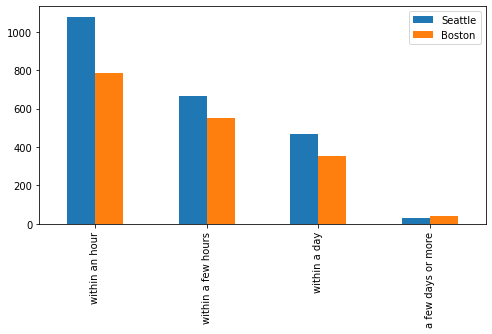

In [237]:
# Below is the code for the question: How responsive are the hosts?

# Remove rows that contain NaN values and duplicates, so that plots can be drawn with processed data.

sea_ls_res=sea_listings[['host_id','host_response_time']].drop_duplicates().dropna(axis=0)
bos_ls_res=bos_listings[['host_id','host_response_time']].drop_duplicates().dropna(axis=0)

# Join both Seattle and Boston dataframes and plot the graph

sea_bos_host = sea_ls_res['host_response_time'].value_counts().rename('Seattle').to_frame()\
               .join(bos_ls_res['host_response_time'].value_counts().rename('Boston').to_frame())

sea_bos_host.plot(kind='bar',figsize=(8, 4))

In [238]:
#Rename id column to listing_id in both seattle and boston dataframes so that they can be merged with \
#respective calender dataframes

sea_listings=sea_listings.rename(columns={'id':'listing_id'})
bos_listings=bos_listings.rename(columns={'id':'listing_id'})
sea_ls_cal=pd.merge(sea_listings, sea_calendar, on='listing_id', how='inner')
bos_ls_cal=pd.merge(bos_listings, bos_calendar, on='listing_id', how='inner')

In [239]:
#Below is the code for the question: How do the prices vary during the year?

#Remove "$", "," and convert price_y value to float in both seattle and boston dataframes

sea_ls_cal["price_y"]=sea_ls_cal.price_y.str.replace('$','').str.replace(',','').astype(float)
bos_ls_cal["price_y"]=bos_ls_cal.price_y.str.replace('$','').str.replace(',','').astype(float)

#Convert all date time columns to dates using function to_date_time (predefined in this notebook)

sea_ls_cal['date'] = to_date_time(sea_ls_cal['date'])
sea_ls_cal['host_since'] = to_date_time(sea_ls_cal['host_since'])
sea_ls_cal['month']=sea_ls_cal.date.dt.month.apply(lambda x: calendar.month_abbr[x])
sea_ls_cal['year']=sea_ls_cal.host_since.dt.year
bos_ls_cal['date'] = to_date_time(bos_ls_cal['date'])
bos_ls_cal['host_since'] = to_date_time(bos_ls_cal['host_since'])
bos_ls_cal['month']=bos_ls_cal.date.dt.month.apply(lambda x: calendar.month_abbr[x])
bos_ls_cal['year']=bos_ls_cal.host_since.dt.year

#Calculate monthly price by grouping by month and aggregating price_y in both seattle and boston dataframes

sea_monthly_price = sea_ls_cal.groupby(['month'])['price_y'].mean().to_frame(name='seattle_price').reset_index()
bos_monthly_price = bos_ls_cal.groupby(['month'])['price_y'].mean().to_frame(name='boston_price').reset_index()
bos_monthly_price

,month,boston_price
0,Apr,197.252890
1,Aug,203.330142
2,Dec,192.601915
3,Feb,180.961028
4,Jan,182.799671
5,Jul,202.486309
6,Jun,196.535302
7,Mar,181.818742
8,May,193.712295
9,Nov,202.924416


In [240]:
# Store the list of months in months list

months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Map the average calculation for each listed month 

mapping = {month: i for i, month in enumerate(months)}
sea_key = sea_monthly_price['month'].map(mapping)    
bos_key = bos_monthly_price['month'].map(mapping)    
sea_monthly_price = sea_monthly_price.iloc[sea_key.argsort()]
bos_monthly_price = bos_monthly_price.iloc[bos_key.argsort()]

In [241]:
bos_monthly_price

,month,boston_price
4,Jan,182.799671
3,Feb,180.961028
7,Mar,181.818742
0,Apr,197.252890
8,May,193.712295
6,Jun,196.535302
5,Jul,202.486309
1,Aug,203.330142
11,Sep,237.047727
10,Oct,233.416248


In [242]:
#Merge both seattle monthly price and boston monthly price into monthly price dataframe, so that I can plot on \
#monthly_price dataframe

monthly_price=pd.merge(sea_monthly_price, bos_monthly_price, on='month', how='inner')

In [243]:
monthly_price

,month,seattle_price,boston_price
0,Jan,122.912176,182.799671
1,Feb,124.293927,180.961028
2,Mar,128.644488,181.818742
3,Apr,135.097005,197.252890
4,May,139.538183,193.712295
5,Jun,147.473137,196.535302
6,Jul,152.094150,202.486309
7,Aug,150.656594,203.330142
8,Sep,143.255949,237.047727
9,Oct,137.031939,233.416248


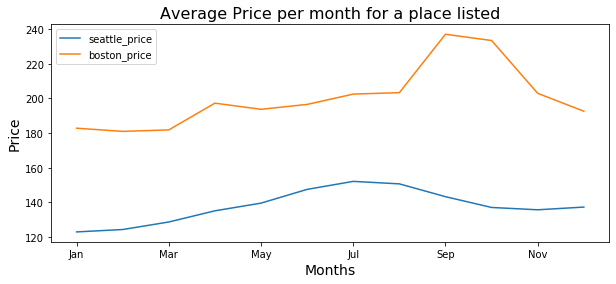

In [244]:
# Plot line graph for seattle monthly price and boston monthly price values

plot_y(monthly_price,'month','seattle_price', 'boston_price', 'Months', 'Price', 'Average Price per month for a place listed', 'line')

In [245]:
# Calculate weekly price by grouping by week and aggregating price_y in both seattle and boston dataframes

sea_weekly_price = sea_ls_cal.groupby(sea_ls_cal['date'].dt.strftime('%w'))['price_y'].mean().to_frame(name='sea_price').reset_index()
bos_weekly_price = bos_ls_cal.groupby(sea_ls_cal['date'].dt.strftime('%w'))['price_y'].mean().to_frame(name='bos_price').reset_index()
sea_weekly_price['date'] = sea_weekly_price['date'].replace(['0','1','2','3','4','5','6'], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
bos_weekly_price['date'] = bos_weekly_price['date'].replace(['0','1','2','3','4','5','6'], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

# Merge both seattle weekly price and boston weekly price into weekly price dataframe, so that I can plot on \
# weekly_price dataframe

weekly_price=pd.merge(sea_weekly_price, bos_weekly_price, on='date', how='inner')
weekly_price

,date,sea_price,bos_price
0,Mon,136.459941,197.384682
1,Tue,135.676414,197.066715
2,Wed,135.408764,197.526889
3,Thu,135.447880,199.029884
4,Fri,136.476032,200.458300
5,Sat,143.036294,199.595434
6,Sun,143.202136,198.059639


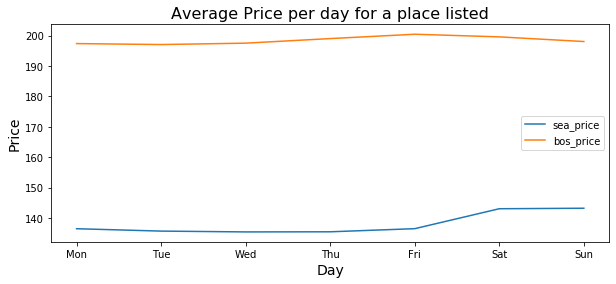

In [246]:
# Plot line graph for seattle weekly price and boston weekly price values

plot_y(weekly_price,'date','sea_price', 'bos_price', 'Day', 'Price', 'Average Price per day for a place listed', 'line')

In [247]:
# Below is the code for the question: How are the prices for different properties?

# Calculate price per property_type by grouping by property_type and aggregating price_y in both seattle and boston dataframes

sea_property_price = sea_ls_cal.groupby(['property_type'])['price_y'].mean().to_frame(name='sea_price').reset_index()
bos_property_price = bos_ls_cal.groupby(['property_type'])['price_y'].mean().to_frame(name='bos_price').reset_index()

# Merge both seattle property price and boston property price into property price dataframe, so that I can plot on \
# property_price dataframe
property_price=pd.merge(sea_property_price,bos_property_price, on='property_type', how='inner')
property_price

,property_type,sea_price,bos_price
0,Apartment,139.285106,214.274243
1,Bed & Breakfast,116.048976,121.138904
2,Boat,330.618901,274.184661
3,Camper/RV,126.931055,60.000000
4,Condominium,169.646416,220.132994
5,Dorm,39.384977,77.370690
6,House,136.627935,140.537793
7,Loft,133.465979,230.022799
8,Other,106.402906,210.326194
9,Townhouse,133.011563,167.577187


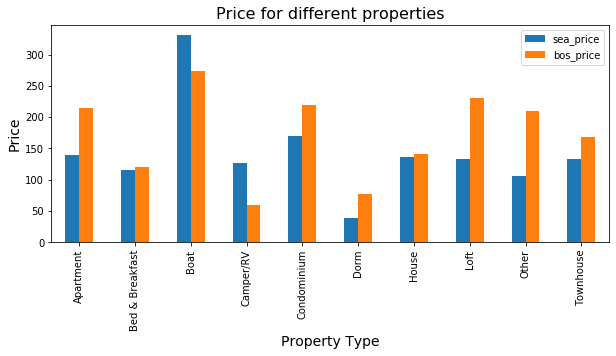

In [248]:
# Plot bar graph for seattle property price and boston property price values

plot_y(property_price,'property_type','sea_price', 'bos_price', 'Property Type', 'Price', 'Price for different properties', 'bar')

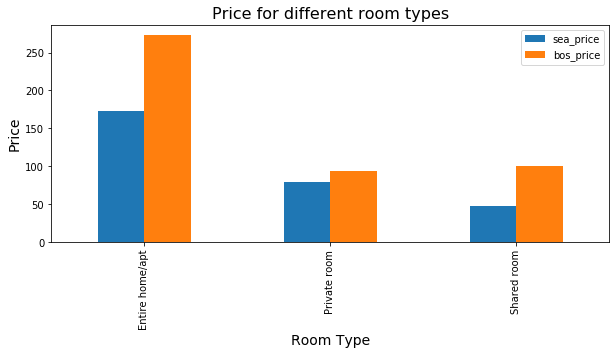

In [249]:
# Calculate price per room_type by grouping by room_type and aggregating price_y in both seattle and boston dataframes

sea_room_price = sea_ls_cal.groupby(['room_type'])['price_y'].mean().to_frame(name='sea_price').reset_index()
bos_room_price = bos_ls_cal.groupby(['room_type'])['price_y'].mean().to_frame(name='bos_price').reset_index()

# Merge both seattle property price and boston room type price into room price dataframe, so that I can plot on \
# room_price dataframe

room_price=pd.merge(sea_room_price,bos_room_price,on='room_type',how='inner')

# Plot bar graph for seattle room type price and boston room type price values

plot_y(room_price,'room_type','sea_price', 'bos_price', 'Room Type', 'Price', 'Price for different room types', 'bar')


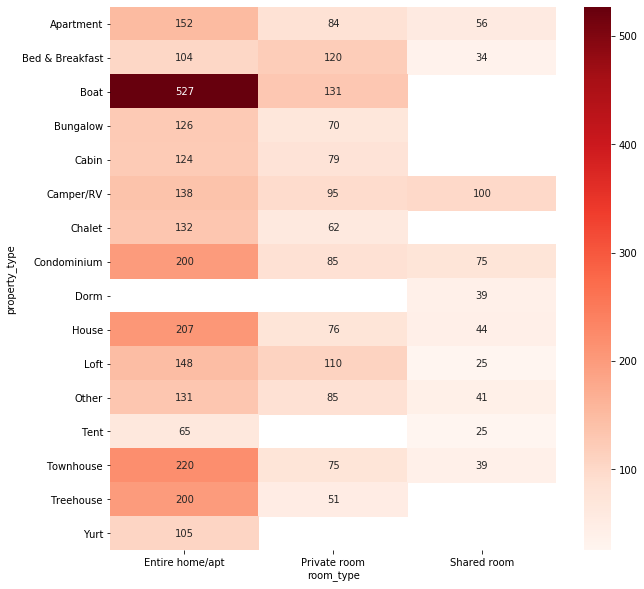

In [250]:
# Plot heatmap for property_type, room_type and price values in seattle

fig, ax = plt.subplots(figsize=(10,10))
sea_heat = sns.heatmap(sea_ls_cal.groupby(['property_type','room_type']).price_y.mean().unstack(),cmap="Reds",annot=True, fmt=".0f",ax=ax);
fig = sea_heat.get_figure()


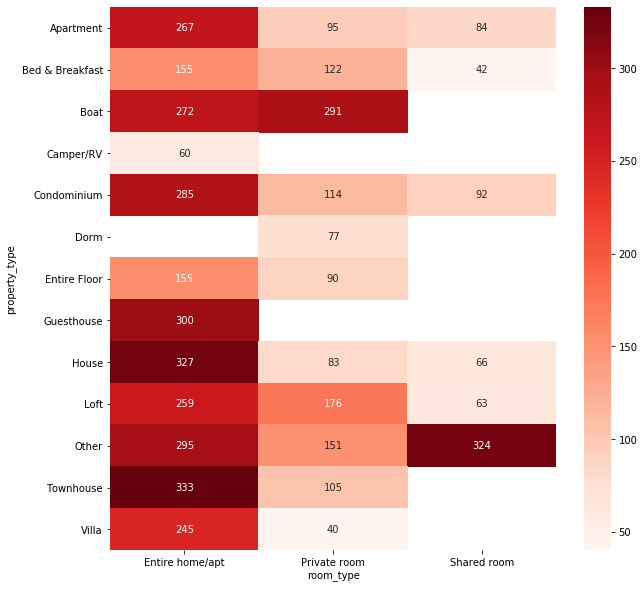

In [251]:
# Plot heatmap for property_type, room_type and price values in Boston

fig, ax = plt.subplots(figsize=(10,10))
sea_heat = sns.heatmap(bos_ls_cal.groupby(['property_type','room_type']).price_y.mean().unstack(),cmap="Reds",annot=True, fmt=".0f",ax=ax);
fig = sea_heat.get_figure()

In [252]:
# Below code is for the question: What is the most popular time of the year?

# Calculate occupancy by using available column in seattle and boston dataframes

sea_ls_cal['occupancy'] = sea_ls_cal['available'] == 'f'
bos_ls_cal['occupancy'] = bos_ls_cal['available'] == 'f'

In [253]:
# Calculate monthly occupancy rates by grouping by month and aggragating occupancy values in seattle and boston dataframes

sea_occupancy_per_month = sea_ls_cal.groupby(sea_ls_cal['date'].dt.strftime('%m'))['occupancy'].mean().to_frame(name='sea_occupancy').reset_index()
sea_occupancy_per_month['month'] = sea_occupancy_per_month['date'].replace(['01','02','03','04','05','06','07','08','09','10','11','12'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
bos_occupancy_per_month = bos_ls_cal.groupby(bos_ls_cal['date'].dt.strftime('%m'))['occupancy'].mean().to_frame(name='bos_occupancy').reset_index()
bos_occupancy_per_month['month'] = bos_occupancy_per_month['date'].replace(['01','02','03','04','05','06','07','08','09','10','11','12'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Merge both seattle monthly occupancy rate and boston monthly occupancy rate into occupancy_per_month dataframe, so that I can plot on \
# occupancy_per_month dataframe

occupancy_per_month=pd.merge(sea_occupancy_per_month,bos_occupancy_per_month,on='month',how='inner')


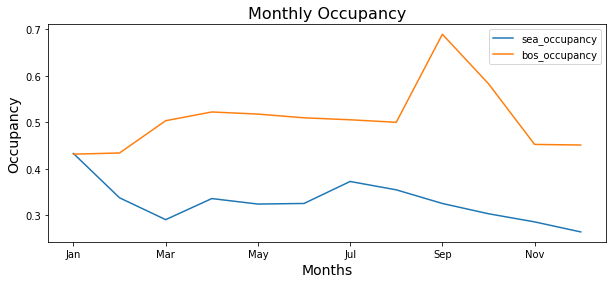

In [254]:
# Plot line graph for seattle monthly occupancy rate and boston monthly occupancy rate

plot_y(occupancy_per_month,'month','sea_occupancy', 'bos_occupancy', 'Months', 'Occupancy', 'Monthly Occupancy', 'line')

In [255]:
# Calculate occupancy per property by grouping by property_type and aggragating occupancy values in seattle and boston dataframes

sea_occupancy_per_property = sea_ls_cal.groupby(sea_ls_cal['property_type'])['occupancy'].mean().to_frame(name='sea_occupancy').reset_index()
bos_occupancy_per_property = bos_ls_cal.groupby(bos_ls_cal['property_type'])['occupancy'].mean().to_frame(name='bos_occupancy').reset_index()

# Merge both seattle occupancy per property and boston occupancy per property into occupancy_per_property dataframe, so that I can plot on \
# occupancy_per_property dataframe

occupancy_per_property=pd.merge(sea_occupancy_per_property,bos_occupancy_per_property,on='property_type',how='inner')

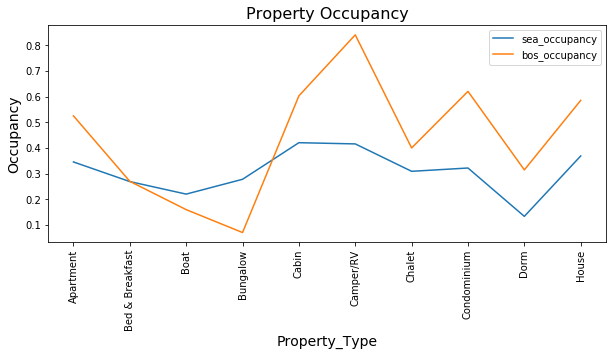

In [256]:
# Plot line graph for seattle occupancy per property and boston occupancy per property values

occupancy_per_property.plot(x='property_type', y=['sea_occupancy', 'bos_occupancy'], figsize=(10,4), kind='line')
plt.title('Property Occupancy',fontsize=16)
plt.xlabel('Property_Type',fontsize=14)
plt.ylabel('Occupancy',fontsize=14)
plt.xticks(np.arange(10),('Apartment', 'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Chalet', 'Condominium', 'Dorm', 'House'), rotation='vertical')
plt.show()

In [257]:
#Below is the code for the question: What factors affect the price in future?

# Drop the rows that are missing price_y values from seattle and boston dataframes

sea_ls_cal = sea_ls_cal.dropna(axis=0, subset=['price_y'])
bos_ls_cal = bos_ls_cal.dropna(axis=0, subset=['price_y'])

# Take potential columns, from seattle and boston dataframes, which could affect the price in future

sea_model=sea_ls_cal[['neighbourhood', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews', 
                'cancellation_policy', 'review_scores_rating', 'price_y']]
bos_model=bos_ls_cal[['neighbourhood', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews', 
                'cancellation_policy', 'review_scores_rating', 'price_y']]

In [258]:
# Check for nulls seattle dataframe

sea_model.isnull().sum()

neighbourhood           106931
property_type              309
room_type                    0
accommodates                 0
bedrooms                  2003
beds                       365
bathrooms                 4803
security_deposit        478121
cleaning_fee            247995
guests_included              0
extra_people                 0
number_of_reviews            0
cancellation_policy          0
review_scores_rating    144537
price_y                      0
dtype: int64

In [259]:
# Check for nulls boston dataframe

bos_model.isnull().sum()

neighbourhood           109325
property_type              148
room_type                    0
accommodates                 0
bedrooms                  3268
beds                      2395
bathrooms                 4454
security_deposit        387036
cleaning_fee            178799
guests_included              0
extra_people                 0
number_of_reviews            0
cancellation_policy          0
review_scores_rating    124360
price_y                      0
dtype: int64

In [93]:
sea_model.shape

(790005, 15)

In [94]:
sea_model.columns

Index(['neighbourhood', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'bathrooms', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'number_of_reviews',
       'cancellation_policy', 'review_scores_rating', 'price_y'],
      dtype='object')

In [260]:
# Below are the categorical variables among the above selected potential columns
# Use get_dummies to create dummy variables for categorical features for the missing values.

categorical_vars = ['neighbourhood', 'property_type', 'room_type', 'cancellation_policy']

for var in categorical_vars:
    sea_model = pd.concat([sea_model.drop(var, axis=1),pd.get_dummies(sea_model[var],prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)
    bos_model = pd.concat([bos_model.drop(var, axis=1),pd.get_dummies(bos_model[var],prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)

In [261]:
# After handling categorical variables above, now replace missing values for numeric features with the mean\
# in both seattle and boston dataframes

var_mean = ['bathrooms', 'bedrooms' ,'beds', 'cleaning_fee','security_deposit', 'accommodates', 'guests_included', \
           'extra_people', 'number_of_reviews', 'review_scores_rating']
imputer = SimpleImputer(strategy="mean")
sea_model[var_mean] = imputer.fit_transform(sea_model[var_mean])
bos_model[var_mean] = imputer.fit_transform(bos_model[var_mean])

In [262]:
# Check if there is any missing values in seattle dataframe

sea_model.isnull().sum()

accommodates                    0
bedrooms                        0
beds                            0
bathrooms                       0
security_deposit                0
                               ..
room_type_nan                   0
cancellation_policy_flexible    0
cancellation_policy_moderate    0
cancellation_policy_strict      0
cancellation_policy_nan         0
Length: 118, dtype: int64

In [263]:
# Check if there is any missing values in boston dataframe

bos_model.isnull().sum()

accommodates                           0
bedrooms                               0
beds                                   0
bathrooms                              0
security_deposit                       0
                                      ..
cancellation_policy_flexible           0
cancellation_policy_moderate           0
cancellation_policy_strict             0
cancellation_policy_super_strict_30    0
cancellation_policy_nan                0
Length: 65, dtype: int64

In [264]:
# Drop if there are any duplicates in both seattle and boston dataframes

sea_model=sea_model.drop_duplicates()
bos_model=bos_model.drop_duplicates()

In [265]:
# Copy everything but price_y into X, and copy price_y into Y

X = sea_model.drop('price_y', axis=1)
Y = sea_model[['price_y']]

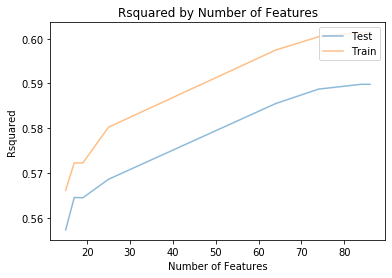

In [266]:
# Call find_optimal_lm_mod function to instantiate, fit, predict and calculate rsquare values.

cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, Y_train, Y_test = find_optimal_lm_mod(X, Y, cutoffs)

In [267]:
# Number of optimal features
print(X_train.shape[1])

# The model we should implement test_r2
print(r2_scores_test[np.argmax(r2_scores_test)])

# The model we should implement train_r2
print(r2_scores_train[np.argmax(r2_scores_test)])

84
0.5898207826499259
0.6014165259801256


In [268]:
# Using Random Forest Regressor to get important features 
rf = RandomForestRegressor(random_state = 42)
# Train the model on training data that we got from above.
rf.fit(X_train, Y_train)

/Users/lakshmikatikala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [270]:
# List the important variables
feature_list = list(X_train)
importances = list(rf.feature_importances_)
Var_importance = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
Var_importance = sorted(Var_importance, key = lambda x: x[1], reverse = True)

Text(0, 0.5, 'Feature Importance Score')

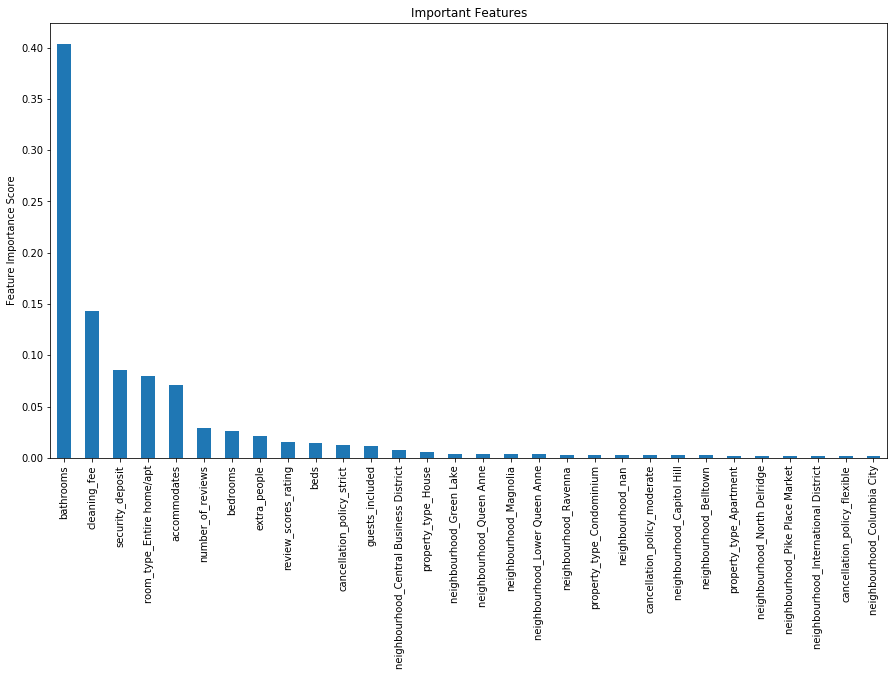

In [271]:
# Plot a bar chart with important features for benchmark model
predictors=list(X_train)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False).head(30)
feat_imp.plot(kind='bar', title='Important Features', figsize=(15,8))
plt.ylabel('Feature Importance Score')

In [272]:
# Copy everything but price_y into X, and copy price_y into Y

X = bos_model.drop('price_y', axis=1)
Y = bos_model[['price_y']]

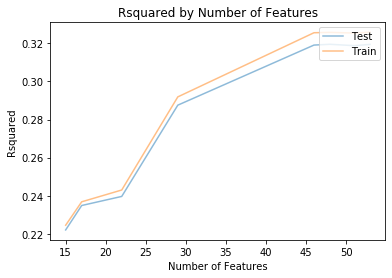

In [273]:
# Call find_optimal_lm_mod function to instantiate, fit, predict and calculate rsquare values.

cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, Y_train, Y_test = find_optimal_lm_mod(X, Y, cutoffs)

In [274]:
#Number of optimal columns
print(X_train.shape[1])

# The model we should implement test_r2
print(r2_scores_test[np.argmax(r2_scores_test)])

# The model we should implement train_r2
print(r2_scores_train[np.argmax(r2_scores_test)])

48
0.31954991926754195
0.32580107116769397


In [276]:
# Using Random Forest Regressor to get important features 
rf = RandomForestRegressor(random_state = 42)
# Train the model on training data that we got from above.
rf.fit(X_train, Y_train)

/Users/lakshmikatikala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [277]:
# List the important variables
feature_list = list(X_train)
importances = list(rf.feature_importances_)
Var_importance = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
Var_importance = sorted(Var_importance, key = lambda x: x[1], reverse = True)

Text(0, 0.5, 'Feature Importance Score')

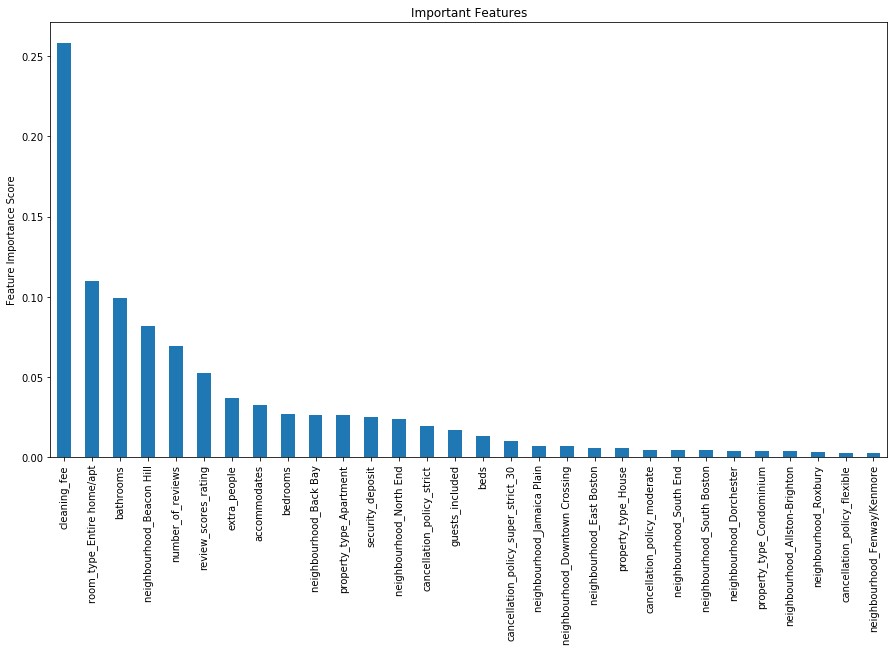

In [278]:
# Plot a bar chart with important features for benchmark model
predictors=list(X_train)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False).head(30)
feat_imp.plot(kind='bar', title='Important Features', figsize=(15,8))
plt.ylabel('Feature Importance Score')